# Credit score prediction

* __Author:__ Gustavo C. Mangold

* __Purpose:__ Develop a credit score model based on data from 150000 clients.

* __Dataset:__ The dataset is provided by Kaggle, from a competition held in 2011 called 'Give me some credit' (available on https://www.kaggle.com/c/GiveMeSomeCredit).

## Introduction
This is my attempt at developing a credit score model from the dataset in hand. This notebook is meant to showcase my thought process working through the dataset, from cleaning to algorithm applying to a final analysis.

The library I made specifically for this case, containing all the learning algorithms, is attached together with the submission, called *personal_library*.

## First steps
To start with, we take a look at the data as a whole, using simple descriptive statistics, which will lead the way to a better first understading and make clear if there are irregulareties in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
#here, the del command only removes a useless column of data, which
#repeated the information in the default df column
df = pd.read_csv('training_data.csv')
del df['Unnamed: 0']
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### First glance at the data
We can already see that the dataset is pretty large, and so, assuming that the data is well distributed, any statistics done in it will have a high reliability. For our problem, we have several variables that will probably have several degrees of importance, so we must take that into account. To estabilish a credit score, we must also take into account that some of the variables might be correlated, which can be used for any machine learning model that will be applied.

The descriptive statistics above, as simple as it is, let's us take a peek at what the dataset offers us. For example, from the mean and std. dev. of __NumberOfDependents__, we see that most of the people in the dataset have between 0 and 1.8 dependents, which might indicate higher financial freedom from a big part of the clients. The analysis also shows us that we might have a problem with outliers in the *PastDue* columns, as we'll see next.

Also, we can see that there are a lot (around $3\cdot 10^4$ data points) with null income, which we must deal with when cleaning the data, which is the next step to be taken.

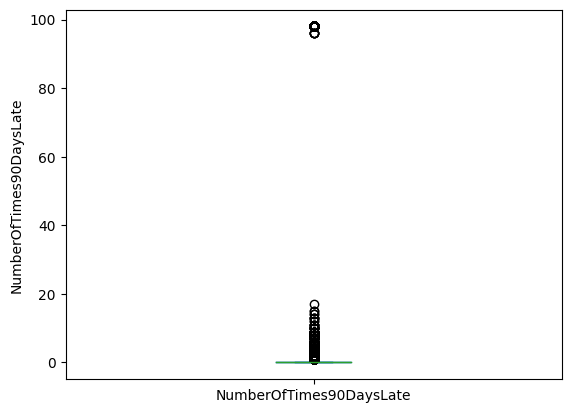

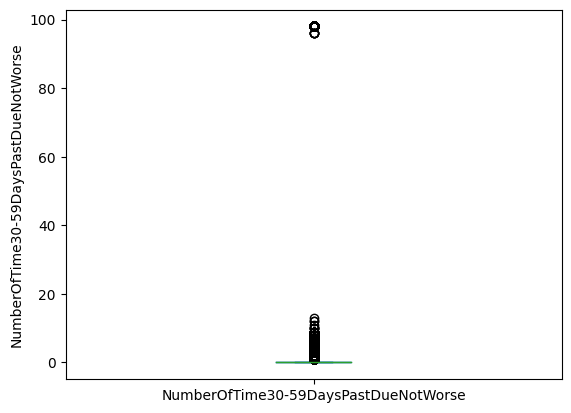

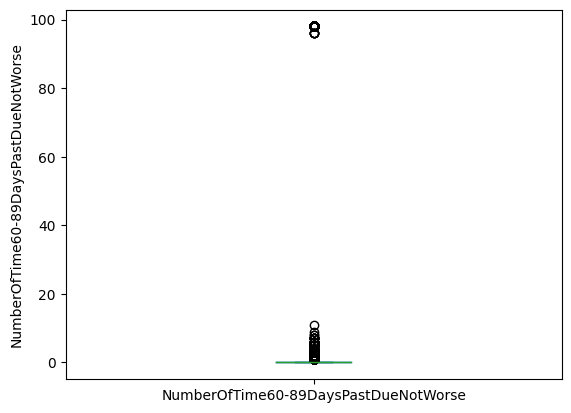

In [3]:
def plot_box(dataframe, x_entry, y_entry):
    dataframe.plot.box(x = x_entry, y = y_entry, ylabel = y_entry, xlabel = '')
    return plt
plot_box(df, 'age', 'NumberOfTimes90DaysLate')
plot_box(df, 'age', 'NumberOfTime30-59DaysPastDueNotWorse')
plot_box(df, 'age', 'NumberOfTime60-89DaysPastDueNotWorse')
#plot_box(df, 'age', 'NumberOfDependents')

#plotting DebtRatio shows us that the distribution might have 'outliers', but they are more well distributed 
#plot_box(df, 'age', 'DebtRatio')
plt.show()

## Cleaning process
From a first look, we can see that there are a lot of NaN data. In fact, running a *df.dropna()* command, we see that, from the initial $15\cdot 10 ^ 4$ rows, we only mantain around $12 \cdot 10^4$, mostly from the __MonthlyIncome__ column, so we must be careful not to erase a considerable chunk of data from the get go.
As there seems to be some outliers on the three __NumberOfTimes[...]__ columns (given that the mean is around $0.5$ for both and the *max* values are $98$), we must take a closer look at those variables, hence the analysis above, showing that there are clearly isolated outliers.

The next steps are taken in order to clean the data having these points in mind. We first exclude the data that has both __NumberOfTimes[...]__ above $90$, which might indicate missing data that was filled in (this isn't a big problem, as it amounts to roughly 270 data points). We could re-enter those points in the distribution, either with the mean or with the current max value of the distribution, but I have decided to take those points out. Also, we fill up the null values using a linear regression model for those data points, seeing what we can achieve with that.

With that done, we will be able to make up a strategy to solve our problem properly.

In [4]:
#this is just a library I made in order not to pollute the code
from personal_library import linear_regression
from sklearn.model_selection import train_test_split

def sub_for_max(column_str, df_w_out = df):
    initial = 0
    for index, row in df[(df[column_str] > 90)].iterrows():
        df_w_out.at[index, column_str] = max(df_w_out[(df_w_out[column_str] < 90)][column_str])
        initial += 1
    
sub_for_max('NumberOfTimes90DaysLate')
sub_for_max('NumberOfTime30-59DaysPastDueNotWorse')
sub_for_max('NumberOfTime60-89DaysPastDueNotWorse')

df_clean_training = df[df['MonthlyIncome'].isnull() == False]
#train, test = train_test_split(df_clean_training, test_size=0.7) 
model = linear_regression(df_clean_training, 'MonthlyIncome')

2023-08-02 18:58:17.329516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 18:58:17.452159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-02 18:58:17.452177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-02 18:58:17.477552: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-02 18:58:17.973758: W tensorflow/stream_executor/platform/de

Epoch 1/30


2023-08-02 18:58:18.431696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-02 18:58:18.431721: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-02 18:58:18.431736: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gustavo-IdeaPad-3-15ALC6): /proc/driver/nvidia/version does not exist
2023-08-02 18:58:18.431893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


421/421 [==============================] - 1s 2ms/step - loss: 39.3174 - val_loss: 18.4527
Epoch 2/30
421/421 [==============================] - 1s 1ms/step - loss: 13.5727 - val_loss: 8.6077
Epoch 3/30
421/421 [==============================] - 1s 1ms/step - loss: 6.4461 - val_loss: 4.9427
Epoch 4/30
421/421 [==============================] - 1s 1ms/step - loss: 4.0421 - val_loss: 3.3144
Epoch 5/30
421/421 [==============================] - 1s 1ms/step - loss: 2.8011 - val_loss: 2.3675
Epoch 6/30
421/421 [==============================] - 1s 2ms/step - loss: 2.0473 - val_loss: 1.7690
Epoch 7/30
421/421 [==============================] - 1s 1ms/step - loss: 1.5617 - val_loss: 1.3761
Epoch 8/30
421/421 [==============================] - 1s 1ms/step - loss: 1.2405 - val_loss: 1.1165
Epoch 9/30
421/421 [==============================] - 1s 1ms/step - loss: 1.0301 - val_loss: 0.9472
Epoch 10/30
421/421 [==============================] - 1s 1ms/step - loss: 0.8952 - val_loss: 0.8378
Epoch 1

In [5]:
import statistics as stat

df_to_predict = df[df['MonthlyIncome'].isnull() == True]
#here, we predict the outputs for income
predicted = model.predict(df_to_predict[df.columns.drop('MonthlyIncome')])
#these are the monthly incomes that are above 0
non_zero_predicted = [x[0] for x in predicted if x >= 0]

print('Total data points with non-zero income predicted: ' + str(len(non_zero_predicted)) + 
     '\nMean and std. dev. of incomes: {:.2f} {:.2f}'
      .format(stat.mean(non_zero_predicted), stat.stdev(non_zero_predicted)))

930/930 [==============================] - 1s 760us/step
Total data points with non-zero income predicted: 1922
Mean and std. dev. of incomes: 2507.47 1739.21


In [6]:
initial = 0
for index, row in df_to_predict.iterrows():
        if predicted[initial] >= 0:
            df.at[index,'MonthlyIncome'] = predicted[initial]
        else: 
            df.at[index,'MonthlyIncome'] = 0
        initial += 1
df.fillna(df['NumberOfDependents'].mean(), inplace = True)

### Remarks on cleaning
After running the linear regression deep learning model in Keras (contained in a library I made attached) to try and obtain data points that were missing back, we can see that there are a lot of data points that are predicted to have negative income. Analysing the data, we see that the negative income predicted comes from the data points which have high __DebtRatio__. 

In fact, most of the null data we have comes from this (we can see that by running a filter, letting us see that the mean debt for the null points is around 1800, while the mean for the dataset as a whole is 353). That indicates that the 'missing data' might be due to some sort of error where a 'negative income' appeared.

My decision was then to zero all the negative predicted incomes, while mantaining the prediction for non-zero data points. In that way, we mantain all the data points while also upgrading the dataset with a couple thousand more incomes to consider. The predictions take around $10^3$ points.

Regarding the null values in the __NumberOfDependents__ column, in order not to lose around $2 \cdot 10^3$ points, I have replaced those values with the mean of the distribution, which makes little to no impact in the column distribution itself, but can make a slight difference in other columns.

In the case of the outliers from the __PastDue__ columns, I have replaced their values with the 'new' maximum of the columns' distribution, which should increase the accuracy of future models. We could replace it with the mean as well, but I think it works best that way.

## Strategy
As the problem requires a credit scoring model, which should be somewhat complementar to elaborating it in terms of how likely one person is to honor a credit debt. The first thing that comes to mind is implementing learning models to determine which of the columns have more impact on a possible non-compliance. For instance, we expect that __age__ will not weight as much as, say, the __PastDue__ columns. 

The problem we're attacking is a little more difficult for not having a clear reference column to compare (this is too ideal, as it would involve already having a pre-set tested model for credit score, which is realistically impossible), which would lead to a simple regression. So, we must employ some algorithms to obtain a prediciton on possible non-compliance. The algorithms used for this idea involve learning the importance of each of the features, in order to estabilish a weight for the columns, and hence, hopefully, be equivalent to a credit score. 

To do that, we use the __SeriousDlq[...]__ column as the predictor, for it is a number between 0 and 1 (can be regarded somewhat as a probability) that showcases best if a person will honor their debt or not, taking into account 2 years prior.

In [7]:
# these fucntions are for plotting the models features

def plot_features(coefficients):
    plot_columns = df.drop('SeriousDlqin2yrs', axis=1)
    n_features = plot_columns.shape[1]    
    
    coef_abs = np.array([abs(x) for x in coefficients])
    feature_importance = pd.DataFrame({'Feature': plot_columns.columns, 'Importance': coef_abs})
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
    
    plt.show()


## Application of learning algorithms
As it seems natural in this problem, we will begin with a regression (not a linear regression, as a logarithmic one is more suitable for this problem). Then, we will apply other types of learning algorithms to see if we can improve our results.

With that, we will calculate the ROC curve for true positive / false negative outputs, obtaining an Area Under Curve (AUC) for each method, letting us decide which method suits the problem better and will produce a better model.

__Observation__: All learning algorithms are present in the library I created called *personal_library*. That was done in order no to overflow the notebook with code, making it simpler and more understandable. 


## Logit Regression
The logarithmic regression is the first that comes to mind, as the nature of the problem presents itself. 

AUC Score model:  0.8153311


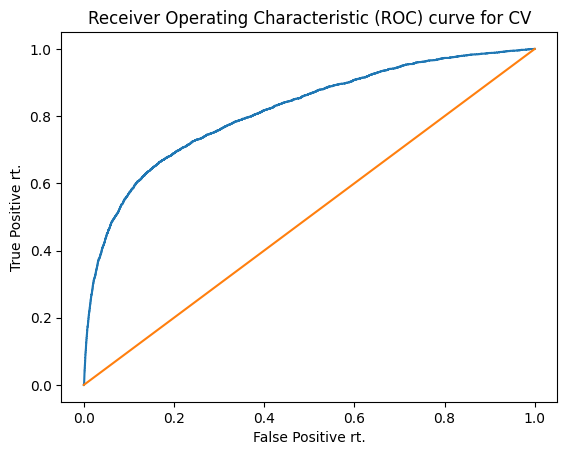

In [8]:
# cell for running the model
from personal_library import random_forest, logit_regression, feature_permutation, gradient_boosting, XG_boosting

lgr = logit_regression(df, 'SeriousDlqin2yrs')

We can see that the logarithmic regression produces a somewhat good ROC curve, with an area under of 0.815. We could be satisfied with it, but as the analysis isn't too hard to do for other types of algorithms, we can search for better approaches.

## Random Forest
The random forest is chosen next, as it is good for feature importance tests.

AUC Score :  0.8460885396535366


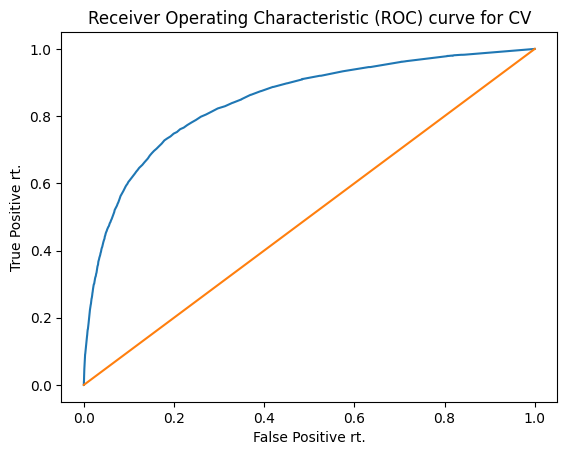

In [9]:
rfc = random_forest(df, 'SeriousDlqin2yrs')

As we can see, the random forest regression brings us a better result, and so we will work with it from now on. Further models can be tested, but I will employ a feature permutation to retrieve the right weights for this one, and, depending on the results, we can decide if it is sufficient to complete our model.

### Feature permutation on random forest
The feature permutation algorithm will exchange columns thoroughly and analyse which permutations increase the total error the most. With that, we will learn which columns are more important for non-compliance, as it was required in the beginning.

In [10]:
pmi_rfc = feature_permutation(df, 'SeriousDlqin2yrs', rfc['Model'])

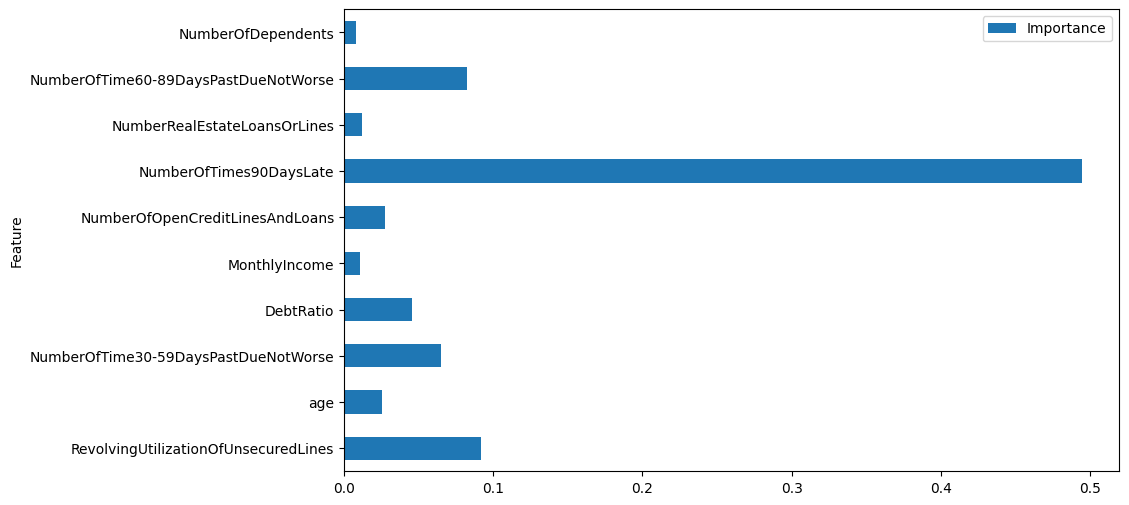

In [11]:
# the scaling is done for better visualization
# as the model predicted weights in the order of 10^-4
pmi_rfc_importances_scaled = [10**2*x for x in pmi_rfc['Importances']]
plot_features(pmi_rfc_importances_scaled)

We got a nice looking result for the model, considering the AUC score, but we will implement one more model for comparison purposes.

## Gradient Boosting

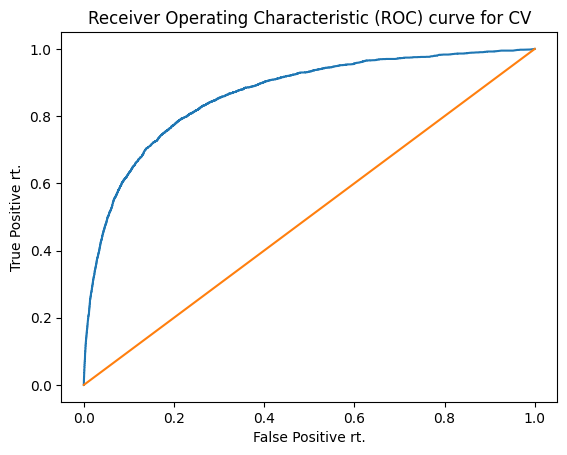

[1.8641474  0.8641474  0.83224574 ... 0.00667925 0.00661781 0.00658617]
AUC Score model:  0.8641454


In [12]:
gb = gradient_boosting(df, 'SeriousDlqin2yrs')

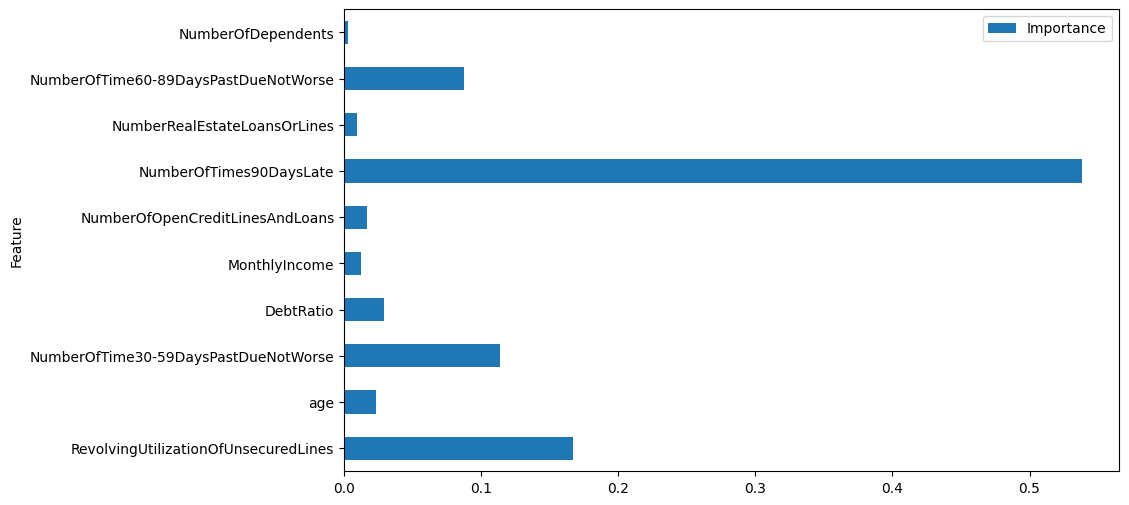

In [13]:
plot_features(gb['Importances'])

### Feature permutation on Gradient Boosting

In [14]:
pmi_gb = feature_permutation(df, 'SeriousDlqin2yrs', gb['Model'])

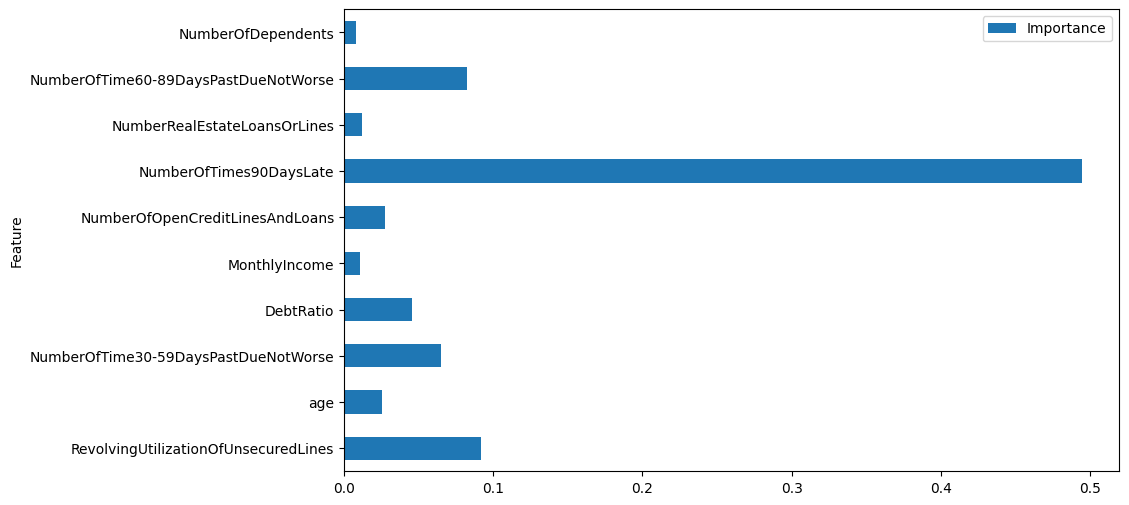

In [15]:
pmi_gb_importances_scaled = [10**2*x for x in pmi_rfc['Importances']]
plot_features(pmi_gb_importances_scaled)

As can be seen by the plot, the feature permutation results agree on gradient boosting agree with random forests, which is a good sign.

## XGboost
As a final test, we will perform a XGboost classifier learning algorithm, as it is (or is supposed to be) a better version of gradient boosting.

[19:02:56] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



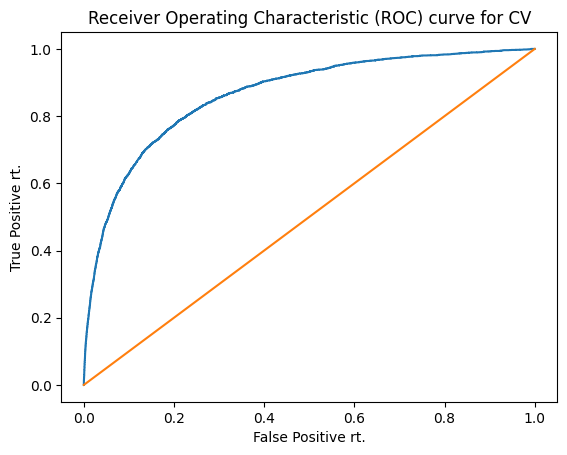

AUC Score model:  0.8646399


In [16]:
xgb = XG_boosting(df, 'SeriousDlqin2yrs')

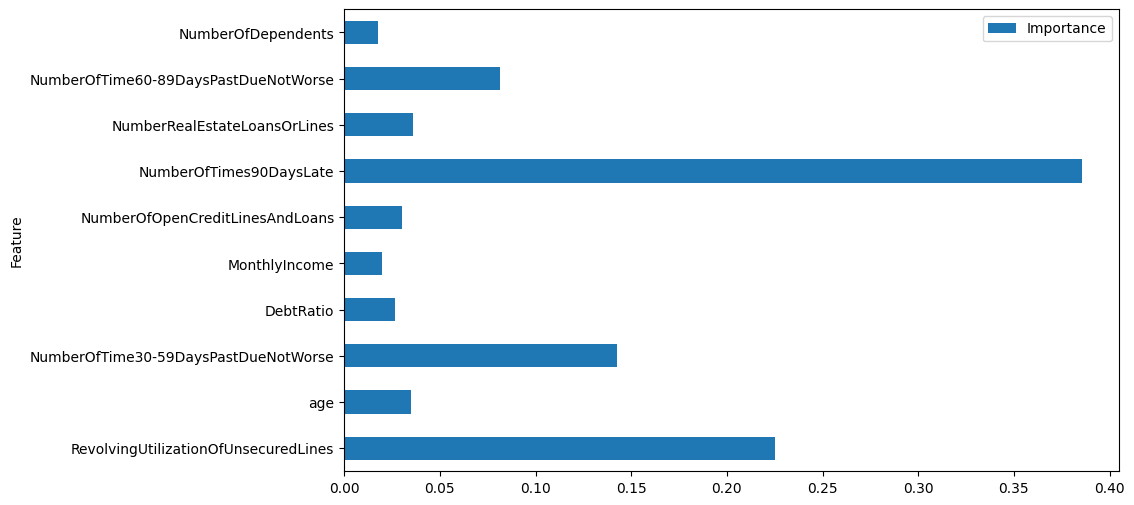

In [17]:
plot_features(xgb['Importances'])

### Feature importance on XGboost

In [18]:
pmi_xgb = feature_permutation(df, 'SeriousDlqin2yrs', xgb['Model'])

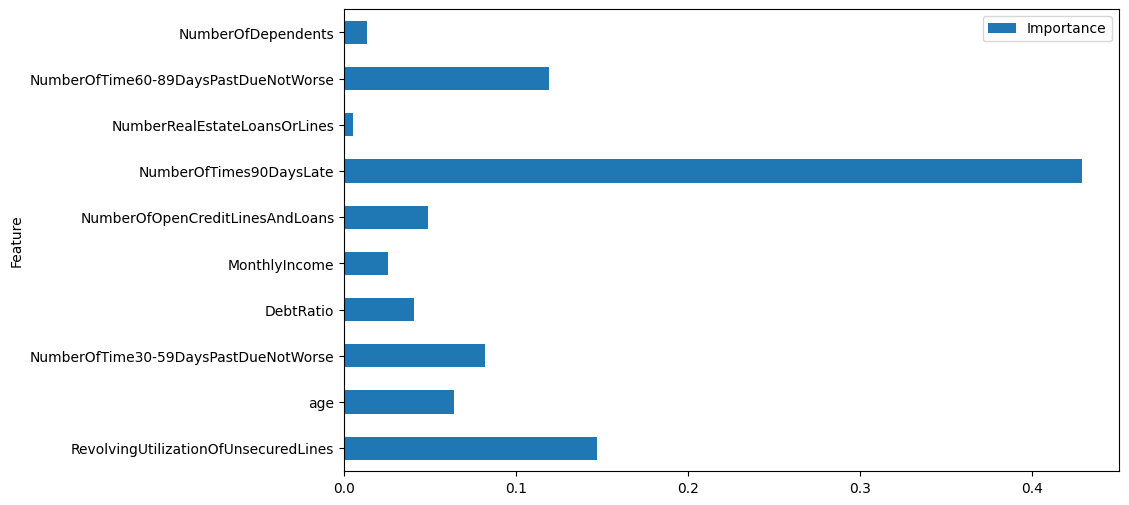

In [19]:
pmi_xgb_importances_scaled = [10**2*x for x in pmi_xgb['Importances']]
plot_features(pmi_xgb_importances_scaled)

## Analysis of the models
We can visualize the AUC for the models using a table:

In [20]:
table_auc = pd.DataFrame({'logit' : lgr['AUC'], 'random forest' : rfc['AUC'], 'gradient boosting' : gb['AUC'], 
              'XGboost' : xgb['AUC']}.items(), columns = ['Model', 'AUC'])
table_auc

,Model,AUC
0,logit,0.815331
1,random forest,0.846089
2,gradient boosting,0.864145
3,XGboost,0.864640


As we can see, the models that have the best performance are the gradient boosting and the XGboost, with very similar AUC's. We can see that the models agree between each other through the permutation importance results, which turn out very similar for the latter two and the random forest, as well as with the models themselves, which indicates that our algorithms are working properly. 

The XGboost is the best choice here, as it provides the greates AUC and have a way faster running time when compared to the other ones. Given that, we will take one more step and perform Hyperparameter tuningn for it, which should give us a refined final model.

## Hyperparameter tuning 
Now that we have estabilished the model we want to use, we can perform a tuning on the parameters to refine it. The chosen method for this is the bayesian optimization.

__I have decided to not use the personal library's xgboost and insted write an own version here, as it showcases the use of the parameters__

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV
from sklearn import datasets, ensemble
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as Xgb

def optimization(df = df, predictor = 'SeriousDlqin2yrs'):
    label = np.array(df[predictor])
    features = df.drop(predictor, axis = 1)

    train, test, train_labels, test_labels =  train_test_split(features, label, test_size = 0.3, random_state = 42)
    scaler_ = StandardScaler().fit(train)
    train_scaled = scaler_.transform(train)
    test_scaled = scaler_.transform(test)

    # define search space
    params = {'max_depth': (0, 20),
        'n_estimators': (100, 500),
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'gamma': (1e-10, 0.5, 'log-uniform'),
        'min_samples_split' : (0, 10),
        'colsample_bytree': [0.7, 0.8, 0.9],}
    # bayesian search
    search = BayesSearchCV(estimator=Xgb.XGBClassifier(), n_iter = 3, search_spaces=params, n_jobs=-1, cv=3, verbose = 1)
    # perform the search
    search.fit(train, train_labels)
    # report the best result
    print(search.best_score_)
    print(search.best_params_)
    return search

In [22]:
optimized = optimization()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[19:04:48] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

0.9367809523809525
OrderedDict([('colsample_bytree', 0.7), ('gamma', 0.0002585017742385541), ('learning_rate', 0.05206036973616247), ('max_depth', 5), ('min_samples_split', 7), ('n_estimators', 468)])


In [23]:
def XG_boosting(df = df, predictor = 'SeriousDlqin2yrs'):
    from sklearn import datasets, ensemble
    import sklearn.metrics as metrics
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    import xgboost as Xgb

    label = np.array(df[predictor])
    features = df.drop(predictor, axis = 1)

    train, test, train_labels, test_labels =  train_test_split(features, label, test_size = 0.3, random_state = 42)
    scaler_ = StandardScaler().fit(train)
    train_scaled = scaler_.transform(train)
    test_scaled = scaler_.transform(test)

    xgb = Xgb.XGBClassifier(gamma = 0.0703, learning_rate = 0.04, max_depth = 8, 
                            n_estimators = 228, min_samples_split = 8, colsample_bytree = 0.8)
    xgb.fit(train_scaled, train_labels)
    xgb_importances = xgb.feature_importances_
    prediction_column = xgb.predict_proba(test_scaled)[:,1]  
    auc = round(metrics.roc_auc_score(test_labels, prediction_column), 7)
    fpr, tpr, threshold = metrics.roc_curve(test_labels, prediction_column)
    print('AUC Score model: ', auc)

    return {'Model': xgb, 'Importances': xgb_importances, 'AUC' : auc}

In [24]:
model_trained_best_parameters = XG_boosting()

[19:05:13] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

AUC Score model:  0.8634737


As can be seen, the AUC score decreased from the original parameters, so I'll stick with the first model weights, as, at this moment, submission is close and I don't have time to find the error that is causing this anomaly.

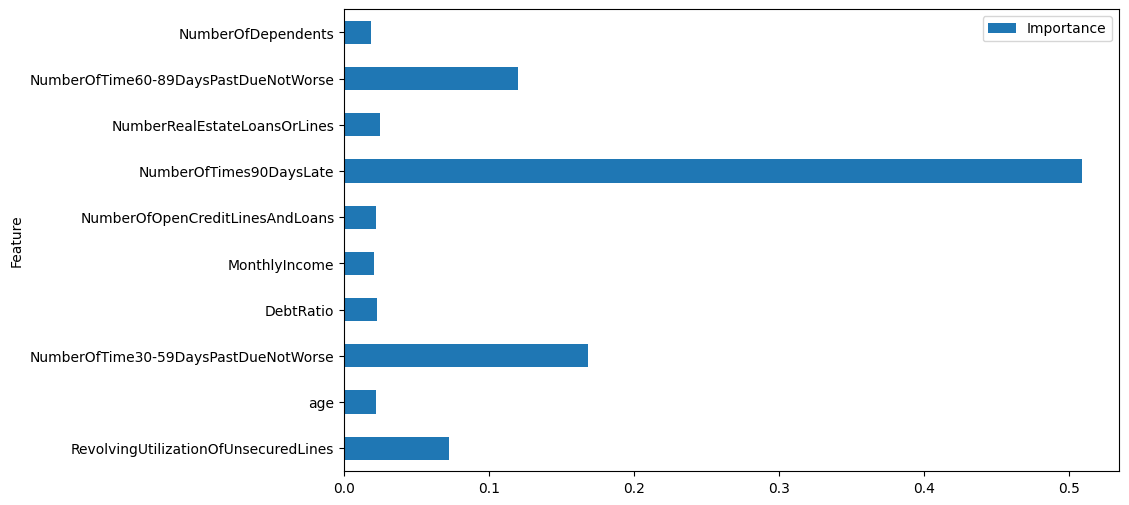

In [25]:
weights = model_trained_best_parameters['Importances']
plot_features(weights)

## Credit score model
With all the analysis done, we are left with utilizing the results. As the initial idea was set, we ought to use the parameters learned by the best performing method to estimate a credit score, but, as said above, the first iteration of the algorithm turned out better than the optimized one. Having said that, the credit score will be set as a linear combination of the columns, with the parameters as weights. Mathematically, we have:

$C_s = 1 - \sum_{i=0}^{i=11} \alpha_i \cdot x_i$

where $C_s$ stands for *Credit score*, the $\alpha$'s are the weights and the $x_i$'s are the column values. We also subtract it from 1, as the model predicts which clients are more likely to be non-compliant. We should check if the score is normalize (which should be, from the nature of the algorithms). If not, we should normalize it by dividing the equation by the range we have, which is found by subtracting the maximum score possible from the minimum score possible.

There is a point to be made for using the *permutation importances* for setting the weights, but I'll stick with the ones provided directly by the model.

In [26]:
normalizer_list = []
for index, row in df.iterrows():
    i = 0
    sum_ = 0
    for weight in weights:
        sum_ += df.iloc[index][i]*weight
    normalizer_list.append(sum_)
print(max(normalizer_list), min(normalizer_list))

1.000000087544322 0.0


As we can see, the score is already normalized. To make it more reasonable for anyone to understand, we can scale the score by 100. So, using a precision of 3 digits (considering the scaling), we have a final model that looks like this:

$C_s = 100 - 7.493 \cdot x_1 + 2.270 \cdot x_2 + 7.493 \cdot x_3 + 16.749 \cdot x_4 + 2.302 \cdot x_5 + 2.139 \cdot x_6 + 2.285 \cdot x_7 + 50.065 \cdot x_8 + 2.529 \cdot x_9 + 12.265 \cdot x_{10} + 1.902 \cdot x_{11}$

considering that if someone falls above 1, the credit score should be set to 1. 

## Credit approval
For this model, we expect, as it is a probability we're dealing with, that on average a client with a score of 70 will honor their debt with a probability of around 70%. For total credit landed (considering all loans taken), I proppose that a good maximum value for credit should be around the total number of months from payout times the monthly income of the person in question. That is, if a person makes 2700 monthly, considering a 12 month payout, the maximum loan amount should be 32400. Of course every case should be analyzed individually, as there are other factors, such as real estate ownership, money in a bank, etc..

A nice idea is to also implement that a minimum score for any given amount of credit. The company in question shouldn't trust anyone with a score below, say, 25. The exact number of the minimum score should also be analyzed case by case, but a good thought might be to offer the full value to people with a score of 95, as it is unrealistic that someone will have a score of 100. Another feature to implement could be using the credit score for changing the loan amount. For example, if someone has the monthly income/prerequisites met for 100000 and has the  and has a score of 60, the company could cap at 60000.

The following table is an idea of a credit approval operation:

In [27]:
pd.DataFrame({'90-100' : 'Full approval', '75-89' : 'Approval of 75%', '50-74' : 'Approval of 50%',
             '25-49': 'Approval of 25%', '0 - 24' : 'Operation not approved'}.items(), 
             columns = ['Credit Score', 'Monthly Inc. x Months'])

,Credit Score,Monthly Inc. x Months
0,90-100,Full approval
1,75-89,Approval of 75%
2,50-74,Approval of 50%
3,25-49,Approval of 25%
4,0 - 24,Operation not approved


[19:03:09] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:03:09] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:03:09] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:03:26] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:03:26] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:03:26] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



## Final remarks and possible improvements
Regarding the model itself, we can see a great impact of the past 90 days due column, as well as a less heavy, but still considerable impact of the other past due columns, as well as the revolving utilization of credit lines, which makes sense, as these indicators intuitively say how much a person is realiable to honor their debts.

Regarding the usefulness of such model, we can see that the initial credit delinquency was around 6.7%, so a model like this can really help a company in terms of profit. Given the amount of money this kind of operation deals with, a decrease of only 1% in deliquency could mean millions of dollars saved. 

Having said that, we are only working with 'toy' models here, as precise as they are. So, for a real operation, we should perform more tests, reconsider the cleanse of the data (and what could be changed in that), and use more algorithms for cross validation. As this was a limited time assignment, I couldn't have done it all the way through, but this is certainly an improvement that should be done.
